In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[yfinance documentation](https://pypi.org/project/yfinance/)

[Geeks for Geeks Tutorial](https://www.geeksforgeeks.org/get-financial-data-from-yahoo-finance-with-python/)

### Canada Oil and Gas

In [6]:
suncor_t = yf.Ticker('SU')
enbridge_t = yf.Ticker('ENB')
cenovus_t = yf.Ticker('CVE')


### Canada Tech


In [7]:
shopify_t = yf.Ticker('SHOP')
constsoft_t = yf.Ticker('CSU')
nuvei_t = yf.Ticker('NVEI')


In [8]:
### Get the ticker stock history in a dataframe ###
### Input the start and end dates and stock symbol ###
def get_tick_hist_df(start, end, symbol):
    
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start, end=end)
    df.title = symbol
    return df

In [9]:
suncor_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'SU')
enbridge_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'ENB')
cenovus_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'CVE')


In [10]:
shopify_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'SHOP')
nvidia_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'NVDA')
c3_df = get_tick_hist_df("2020-04-01", "2022-04-01", 'AI')

In [11]:
def plot_col(df,column):
    df[column].to_frame().plot()


<AxesSubplot:xlabel='Date'>

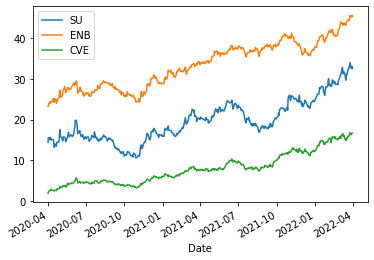

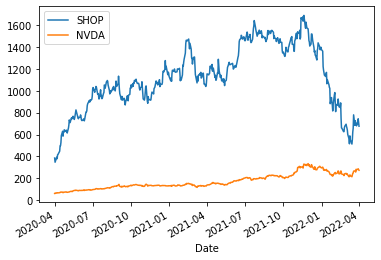

In [12]:
# Plot multiple stocks together in same plot
# Inputs are a list of stock history dataframes and the column to plot #

def plot_mult_dfs(dfs, column):
    data = {}
    for df in dfs:
        data[df.title] = df[column].values
    while True:
        try: 
            index = dfs[0].index
            new_df = pd.DataFrame(data, index=index)
            return new_df.plot()
        except ValueError:
            print("Length of data doesn't match")
            return

    
plot_mult_dfs([suncor_df, enbridge_df, cenovus_df], 'Close')
plot_mult_dfs([shopify_df, nvidia_df], 'Close')


In [13]:
# Create list of stocks to then plot against eachother 
# Input start and end date for stock history
# List of stock symbols
# Column to plot - usually 'Close' which is the closing price

def plot_shares(start, end, stocks, column):
    dfs = []
    for stock in stocks:
        df = get_tick_hist_df(start, end, stock)
        dfs.append(df)
    plot_mult_dfs(dfs, column)

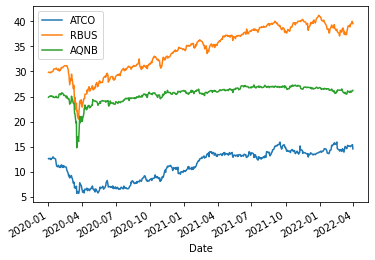

In [14]:
rand_stocks = ['ATCO', 'RBUS', 'AQNB']
plot_shares("2020-01-01", "2022-04-01", rand_stocks, 'Close')


In [15]:
# plot_col(suncor_df,'Close')
# plot_col(enbridge_df, 'Close')
# plot_col(cenovus_df, 'Close')

## 2.3 Trending Data
### Check stocks trend using differencing method
Essentialy taking the derivative  
Goal is to make stationary data  
Marginal price = prices that are the difference b/w yesterday's price and todays price  
Difference Column = y(t) - y(t-1)  


In [16]:
def plot_difference(start, end, stocks, column):
    for stock in stocks:
        df = get_tick_hist_df(start, end, stock)
        df_prices = df[column].to_frame()
        df_prices['Differences'] = df_prices[column] - df_prices[column].shift()
        df_diff = df_prices['Differences'].to_frame()
        df_diff.plot()

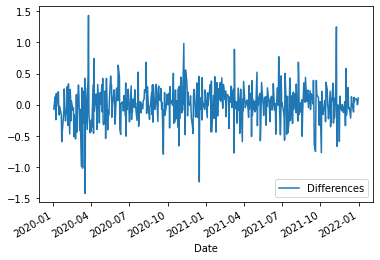

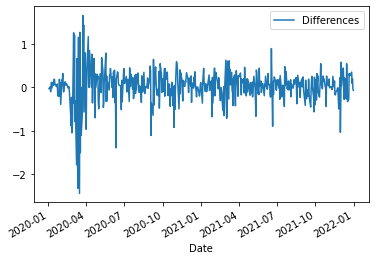

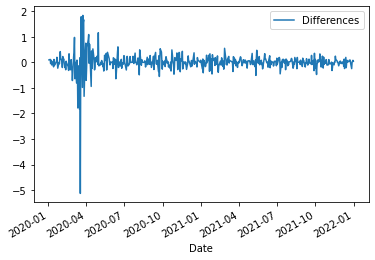

In [17]:
plot_difference('2020-01-01', '2022-01-01', rand_stocks, 'Close')

## 2.4 - 2.6 Seasonality

Idea is to subtract the amount of change that just happened because of the "season"  
Procedure: 
- compute mean for whole data set
- compute mean for each seasonal timeframe (ect. each month, each day of week)
- compute offset for each month = mean(month) - mean(total)
- create new series = value - offsets

Check atco for seasonality

### Calculate Season Means

In [18]:
# compute the means for each season
# takes the data frame, the column for the value, and the number of seasons (12, 4, etc.)
# returns the mean for each season
def get_season_means(df, column, num_seasons):
    season_sum = [0]*num_seasons
    season_count = [0]*num_seasons
    season_mean = [0]*num_seasons
    # use running totals to get monthly sum and monthly count
    for i, value in enumerate(df[column]):
        season_sum[i % num_seasons] += df[column][i]
        season_count[i % num_seasons] += 1
    # calculate monthly avg
    for i in range(num_seasons):
        season_mean[i] = season_sum[i] / season_count[i]
    return season_mean


### Calculate Overall Mean

In [19]:
def get_overall_mean(df, column):
    mean = np.mean(df[column].values)
    return mean


### Calculate Season Offsets

In [20]:
def get_season_offsets(mean, season_means, num_seasons):
    season_offsets = [0]*num_seasons
    for i in range(num_seasons):
        season_offsets[i] = season_means[i] - mean
    return season_offsets


### Calculate Seasonally Adjusted Data
Use offsets to calculate seasonally offset data and create a new column in the DF

In [35]:
def get_seasonally_adj_values(df, column, offsets):
    new_df = df.copy()
    seasonally_adj = []
    num_seasons = len(offsets)
    for i, val in enumerate(df[column]):
        seasonally_adj.append( val - offsets[i % num_seasons])
    new_df.insert(1, 'Seasonally Adjusted', seasonally_adj)
    return new_df


In [36]:
### Bring it all together in one function

def get_seasonal_adj_df(df, column, num_seasons):
    season_means = get_season_means(df,column, num_seasons)
    overall_mean = get_overall_mean(df, column)
    offsets = get_season_offsets(overall_mean, season_means, num_seasons)
    adj_df = get_seasonally_adj_values(df, column, offsets)
    return adj_df

### Test Seasonal Dataset - Monthly Eco station users
Can see some pretty seasonal looking data

<AxesSubplot:xlabel='Month'>

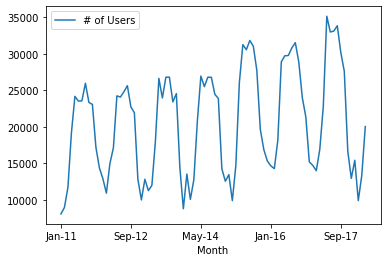

In [58]:
# ECOSTATION MONTHLY USERS
eco_df = pd.read_csv('./data/Eco_Station_Users_Monthly.csv').sort_values(by=['ID #'])
eco_df = eco_df.drop(columns=['Year','DateTime'])
eco_df.plot(x='Month', y='# of Users')
# eco_df.head()


<AxesSubplot:xlabel='MONTH'>

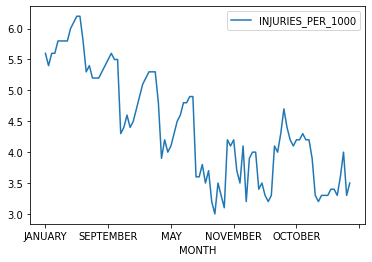

In [59]:
# Traffic Injuries
traffic_inj_df = pd.read_csv('./data/Traffic_Injury_Information.csv')
traffic_inj_df.plot(x='MONTH',y='INJURIES_PER_1000')

<AxesSubplot:xlabel='Date'>

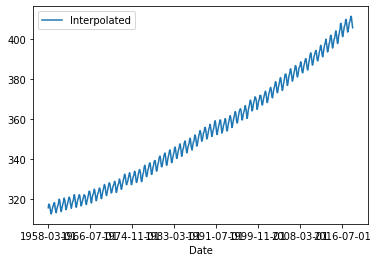

In [47]:
#CO2 MONTHLY
co2_monthly_df = pd.read_csv('./data/CO2_monthly.csv')
co2_monthly_df.head()
co2_monthly_df.plot(x='Date', y='Interpolated')

<AxesSubplot:xlabel='Date'>

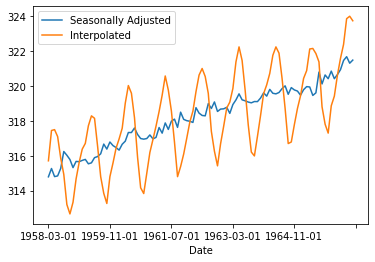

In [49]:
co2_monthly_adj = get_seasonal_adj_df(co2_monthly_df[:100], 'Interpolated', 12)
co2_monthly_adj.plot(x='Date', y=['Seasonally Adjusted', 'Interpolated'])

<AxesSubplot:xlabel='MONTH'>

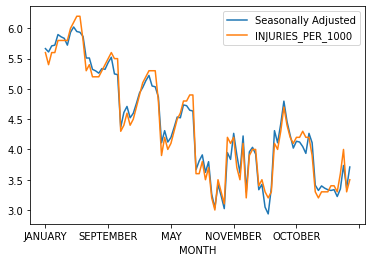

In [43]:
traf_inj_adj = get_seasonal_adj_df(traffic_inj_df, 'INJURIES_PER_1000', 12)
traf_inj_adj.plot(x='MONTH', y=['Seasonally Adjusted', 'INJURIES_PER_1000'])

<AxesSubplot:xlabel='Month'>

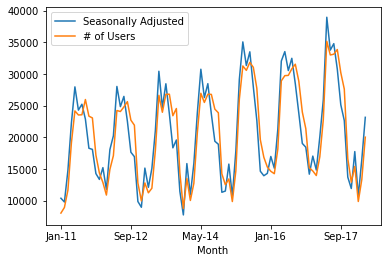

In [39]:
eco_df_adj2 = get_seasonal_adj_df(eco_df, '# of Users', 12)
eco_df_adj2.head()
eco_df_adj2.plot(x='Month', y=['Seasonally Adjusted', '# of Users'])

# Seasonally Adjust for stock data
However stocks aren't seasonal so think I can get rid of this but can keep around for now

In [55]:
def get_seasonally_adjuted_stock_data(start, end, symbol, num_seasons):
    df = get_tick_hist_df(start, end, symbol)
    df_price = df['Close'].to_frame()
    adj_df = get_seasonal_adj_df(df_price, 'Close', num_seasons)
    # seasonal_means = get_season_means(df_price, 'Close', num_seasons)
    # overall_mean = get_overall_mean(df_price, 'Close')
    # seasonal_offsets = get_season_offsets(overall_mean, seasonal_means, num_seasons)
    # print(seasonal_offsets)
    # adjusted_df = get_seasonally_adj_df(df_price, 'Close', seasonal_offsets)
    return adj_df

    

In [56]:
df_stock_adj = get_seasonally_adjuted_stock_data('2000-01-01','2020-01-01','VNO', 12)
# atco_adj['Seasonally Adjusted'].plot()
# df_adj.plot(figsize=(15,10))

# Multiplicative & Additive Series
In multiplicative series the seasonality increases from season to season.  
Think of next step as the product of the last two  
(Additive = next step sum of last two)

#### Check for multiplicativity:  
- make a scatter plot of the differences against the values (derivative)
- if it looks largely like a rising line => multiplicative

#### Check for Additive Series:
- make scatter plot of the differences against values (derivative)
- if looks like a flat line => additive

In [63]:
def plot_derivative(df, col):
    new_df = df.copy()
    new_df['diff'] = np.abs(new_df[col] - new_df[col].shift())
    new_df.plot.scatter(x=col, y='diff')

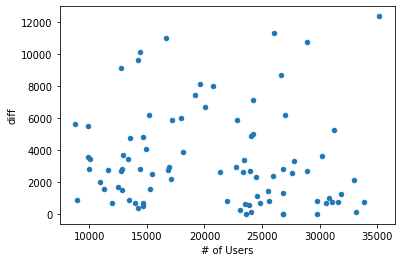

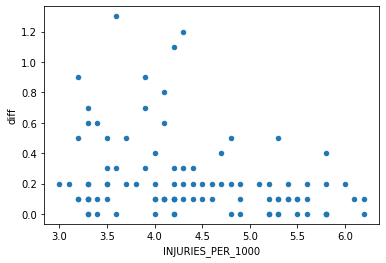

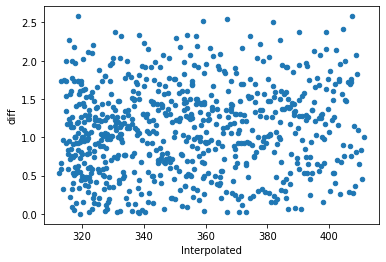

In [66]:
# can't tell much
plot_derivative(eco_df, '# of Users')
#looks pretty flat
plot_derivative(traffic_inj_df, 'INJURIES_PER_1000')

plot_derivative(co2_monthly_df, 'Interpolated')

All the series look fairly flat.

https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python/data?select=AirPassengers.csv

In [68]:

air_pass_df = pd.read_csv('./data/AirPassengers.csv')


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


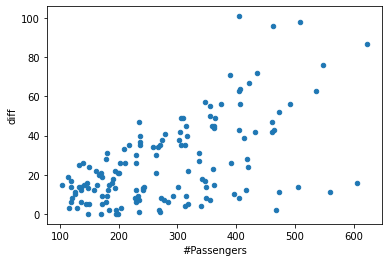

In [69]:
plot_derivative(air_pass_df, '#Passengers')

### To deal with multiplicative series use the logs of the value.

In [76]:
def get_log_diff(df, col):
    new_df = df.copy()
    new_df['log_val'] = np.log(new_df[col])
    new_df['log_diff'] = np.abs(new_df['log_val'] - new_df['log_val'].shift())
    new_df.plot.scatter(x='log_val', y='log_diff')
    return new_df

,Month,#Passengers,log_val,log_diff
0,1949-01,112,4.718499,NaN
1,1949-02,118,4.770685,0.052186
2,1949-03,132,4.882802,0.112117
3,1949-04,129,4.859812,0.022990
4,1949-05,121,4.795791,0.064022


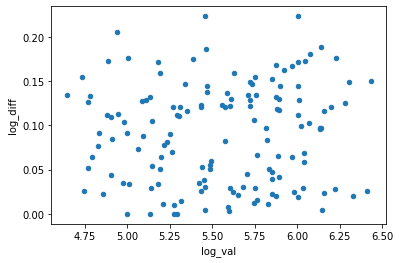

In [77]:
air_pass_log_df = get_log_diff(air_pass_df, '#Passengers')
air_pass_log_df.head()


Now the log of the value looks additive instead of multiplicative.